In [10]:
!pip install sklearn

ERROR: Could not find a version that satisfies the requirement imblearn.over_sampling (from versions: none)
ERROR: No matching distribution found for imblearn.over_sampling


In [52]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
#import cv2
import gc
import matplotlib.pyplot as plt
#import openslide
#from openslide.deepzoom import DeepZoomGenerator
import tifffile as tifi
import sklearn

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import vgg16, vgg19, resnet50, mobilenet, inception_resnet_v2, densenet, inception_v3, xception, nasnet, ResNet152V2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, InputLayer, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adamax

from imblearn.over_sampling import RandomOverSampler

In [53]:
import tensorflow as tf
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

: /physical_device:CPU:0
: /physical_device:GPU:0


In [150]:
import random
import torch
seed = 123
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed)

In [180]:
#df_0 = os.path.join('../input/blurrpca20mean-00/00')
df_0 = os.path.join('Scaled/NoBlurr/NoBlurr-PCA-20-Stand/00/')
x0 = [i for i in os.listdir(df_0) if not i.startswith(".")]
x0 = pd.DataFrame(x0, columns = ['file_name'])
x0['file_name'] = 'Scaled/NoBlurr/NoBlurr-PCA-20-Stand/00/' + x0['file_name']
x0['label'] = 'No_DB'
print(x0.shape)
x0.head(2)

(118621, 2)


,file_name,label
0,Scaled/NoBlurr/NoBlurr-PCA-20-Stand/00/018833.png,No_DB
1,Scaled/NoBlurr/NoBlurr-PCA-20-Stand/00/132782.png,No_DB


In [181]:
#df_1 = os.path.join('../input/blurrpca20mean-01/01')
df_1 = os.path.join('Scaled/NoBlurr/NoBlurr-PCA-20-Stand/01/')
x1= [i for i in os.listdir(df_1) if not i.startswith(".")]
x1 = pd.DataFrame(x1, columns = ['file_name'])
x1['file_name'] = 'Scaled/Mean/NoBlurr/NoBlurr-PCA-20-Stand/01/' + x1['file_name']
x1['label'] = 'Yes_DB'
print(x1.shape)
x1.head(2)

(14787, 2)


,file_name,label
0,Scaled/Mean/NoBlurr/NoBlurr-PCA-20-Stand/01/09...,Yes_DB
1,Scaled/Mean/NoBlurr/NoBlurr-PCA-20-Stand/01/03...,Yes_DB


In [182]:
df = pd.concat([x0, x1])
print(df['label'].value_counts())
print(df['file_name'].iloc[0])
df.head(5)

No_DB     118621
Yes_DB     14787
Name: label, dtype: int64
Scaled/NoBlurr/NoBlurr-PCA-20-Stand/00/018833.png


,file_name,label
0,Scaled/NoBlurr/NoBlurr-PCA-20-Stand/00/018833.png,No_DB
1,Scaled/NoBlurr/NoBlurr-PCA-20-Stand/00/132782.png,No_DB
2,Scaled/NoBlurr/NoBlurr-PCA-20-Stand/00/050115.png,No_DB
3,Scaled/NoBlurr/NoBlurr-PCA-20-Stand/00/122370.png,No_DB
4,Scaled/NoBlurr/NoBlurr-PCA-20-Stand/00/047634.png,No_DB


In [183]:
df_x = df.drop('label', axis = 1)
df_y = df['label']


X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size = 0.40, random_state = 123)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.50, random_state = 123)

In [184]:
ros = RandomOverSampler(sampling_strategy = 'auto', random_state = 123)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [185]:
df_train = pd.concat([X_train, y_train], axis = 1)
df_test = pd.concat([X_test, y_test], axis = 1)
df_val = pd.concat([X_val, y_val], axis = 1)

In [186]:
print(df_train['label'].value_counts())
print(' ')
print(' ')
print(df_test['label'].value_counts())
print(' ')
print(' ')
print(df_val['label'].value_counts())

No_DB     71222
Yes_DB    71222
Name: label, dtype: int64
 
 
No_DB     23723
Yes_DB     2959
Name: label, dtype: int64
 
 
No_DB     23676
Yes_DB     3006
Name: label, dtype: int64


In [187]:
train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)
teste_datagen = ImageDataGenerator(rescale = 1./255)

In [188]:
df_train.head(5)

,file_name,label
0,Scaled/NoBlurr/NoBlurr-PCA-20-Stand/00/077343.png,No_DB
1,Scaled/NoBlurr/NoBlurr-PCA-20-Stand/00/067604.png,No_DB
2,Scaled/NoBlurr/NoBlurr-PCA-20-Stand/00/049177.png,No_DB
3,Scaled/NoBlurr/NoBlurr-PCA-20-Stand/00/057109.png,No_DB
4,Scaled/Mean/NoBlurr/NoBlurr-PCA-20-Stand/01/06...,Yes_DB


In [189]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(142444, 2)
(26682, 2)
(26682, 2)


In [190]:
image_length = 32
image_height = 32

In [191]:
train_iter = train_datagen.flow_from_dataframe(
    df_train, 
    target_size = (image_length, image_height),
    x_col = 'file_name',
    y_col = 'label',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True
)

/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 71222 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


Found 71222 validated image filenames belonging to 1 classes.


In [192]:
valid_iter = train_datagen.flow_from_dataframe(
    df_val, 
    target_size = (image_length, image_height),
    x_col = 'file_name',
    y_col = 'label',
    class_mode = 'categorical',
    batch_size = 32
)

Found 23676 validated image filenames belonging to 1 classes.


/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 3006 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


In [193]:
test_iter = train_datagen.flow_from_dataframe(
    df_test, 
    target_size = (image_length, image_height),
    x_col = 'file_name',
    y_col = 'label',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True
)

/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 2959 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


Found 23723 validated image filenames belonging to 1 classes.


In [194]:
print(train_iter.image_shape)
print(valid_iter.image_shape)
print(test_iter.image_shape)

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


In [195]:
#model = tf.keras.models.Sequential()

#model.add(tf.keras.layers.Conv2D(256, (1, 1), activation = 'relu', input_shape = (image_length, image_height, 3)))
#model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

#model.add(tf.keras.layers.Conv2D(64, (1, 1), activation = 'relu'))
#model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

#model.add(tf.keras.layers.Conv2D(32, (1, 1), activation = 'relu'))
#model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

#model.add(tf.keras.layers.Conv2D(16, (1, 1), activation = 'relu'))
#model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

#model.add(tf.keras.layers.Flatten())
#model.add(tf.keras.layers.Dense(8, activation = 'relu'))
#model.add(tf.keras.layers.Dropout(0.5))

#model.add(tf.keras.layers.Dense(2, activation = 'softmax'))

In [196]:
model = vgg16.VGG16(
                    input_shape = (image_length, image_height, 3),
                    include_top = False,
                    pooling = 'avg',
                    weights = 'imagenet'
                    )


model.trainable = False


x = Dense(2,
          activation = 'softmax',
          name = 'new_output')(model.output) 


model = Model(model.input, x)

In [197]:
METRICS = [
      tf.keras.metrics.TruePositives(name = 'tp'),
      tf.keras.metrics.FalsePositives(name = 'fp'),
      tf.keras.metrics.TrueNegatives(name = 'tn'),
      tf.keras.metrics.FalseNegatives(name = 'fn'), 
      tf.keras.metrics.BinaryAccuracy(name ='accuracy'),
      tf.keras.metrics.Precision(name = 'precision'),
      tf.keras.metrics.Recall(name = 'recall'),
      tf.keras.metrics.AUC(name = 'auc'),
]

In [198]:
model.compile(
                #optimizer = sgd,
                #optimizer = opt,
                optimizer = 'adam',
                #optimizer = 'Adadelta',
                #optimizer = 'Adamax',
                
                metrics = METRICS,
                #metrics = ['accuracy'],
                #metrics = ['mse'],
                
                #loss = 'binary_crossentropy'
                loss = 'categorical_crossentropy'
                #loss = 'mean_absolute_error'
                #loss = 'mse'
                #loss = 'mean_squared_logarithmic_error'
                )

In [199]:
checkpointpath = "./Baseline.h5"
checkpoint = ModelCheckpoint(checkpointpath, 
                             #monitor = 'val_accuracy', 
                             monitor = 'val_loss',
                             verbose = 0, 
                             save_best_only = True,
                             #mode = 'max'
                             mode = 'min'
                             )
callbacks_list = [checkpoint]

In [200]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.1,
                              patience = 1, 
                              min_lr = 0.0001,
                              cooldown = 1)

In [201]:
early_stop = EarlyStopping(monitor = 'val_loss', 
                           patience = 5,
                           mode = 'min')

In [203]:
number_epoch = 5


modelfitprogress2 = model.fit(
                              train_iter,
                              validation_data = valid_iter,
                              epochs = number_epoch,
                              steps_per_epoch = df_train.shape[0]//train_iter.batch_size,
                              validation_steps = df_val.shape[0]//valid_iter.batch_size,
                              callbacks = [reduce_lr, early_stop, checkpoint]
                              )

Epoch 1/5


2022-11-15 14:59:51.372948: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at segment_reduction_ops_impl.h:482 : INVALID_ARGUMENT: data.shape = [32] does not start with segment_ids.shape = [64]
2022-11-15 14:59:51.374111: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at segment_reduction_ops_impl.h:482 : INVALID_ARGUMENT: data.shape = [32] does not start with segment_ids.shape = [64]


InvalidArgumentError: Graph execution error:

Detected at node 'UnsortedSegmentSum' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
      await result
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_8543/1842867924.py", line 4, in <cell line: 4>
      modelfitprogress2 = model.fit(
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/engine/training.py", line 894, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/engine/training.py", line 987, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 501, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/metrics/metrics.py", line 1759, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 628, in update_confusion_matrix_variables
      return _update_confusion_matrix_variables_optimized(
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 426, in _update_confusion_matrix_variables_optimized
      tp_bucket_v = tf.math.unsorted_segment_sum(
Node: 'UnsortedSegmentSum'
Detected at node 'UnsortedSegmentSum' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
      await result
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_8543/1842867924.py", line 4, in <cell line: 4>
      modelfitprogress2 = model.fit(
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/engine/training.py", line 894, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/engine/training.py", line 987, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 501, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/metrics/metrics.py", line 1759, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 628, in update_confusion_matrix_variables
      return _update_confusion_matrix_variables_optimized(
    File "/home/manwest/Documentos/Jupyter/jupyterEnv/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 426, in _update_confusion_matrix_variables_optimized
      tp_bucket_v = tf.math.unsorted_segment_sum(
Node: 'UnsortedSegmentSum'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  data.shape = [32] does not start with segment_ids.shape = [64]
	 [[{{node UnsortedSegmentSum}}]]
	 [[assert_less_equal_2/Assert/AssertGuard/pivot_f/_53/_107]]
  (1) INVALID_ARGUMENT:  data.shape = [32] does not start with segment_ids.shape = [64]
	 [[{{node UnsortedSegmentSum}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_1613338]

In [ ]:
plt.plot(modelfitprogress2.history['loss'], color = 'red', label = 'loss')
plt.plot(modelfitprogress2.history['val_loss'], color = 'green', label = 'val loss')
plt.legend(loc = 'upper right')
plt.show()

In [ ]:
plt.plot(modelfitprogress2.history['accuracy'], color = 'red', label = 'accuracy')
plt.plot(modelfitprogress2.history['val_accuracy'], color = 'green', label = 'val accuracy')
plt.legend(loc = 'upper right')
plt.show()

In [ ]:
model = load_model('./Baseline.h5')

In [ ]:
score = model.evaluate(valid_iter, steps = df_val.shape[0]//valid_iter.batch_size)
print("Loss in validation: {} \nAccuracy in validation: {}".format(score[0], score[5]))

In [ ]:
score = model.evaluate(test_iter, steps = df_test.shape[0]//test_iter.batch_size)
print("Loss in test: {} \nAccuracy in test: {}".format(score[0], score[5]))

In [ ]:
print(train_iter.class_indices)
print(test_iter.class_indices)
print(valid_iter.class_indices)

In [ ]:
prediction = model.predict(test_iter, steps = np.math.ceil(test_iter.samples/test_iter.batch_size))
print(prediction)

In [ ]:
predicted_classes = np.argmax(prediction, axis = 1)
print(predicted_classes)

In [123]:
x = pd.DataFrame(predicted_classes, columns = ['class'])
x['class'].value_counts()

0    15772
1    10910
Name: class, dtype: int64

In [124]:
true_classes = test_iter.classes
class_labels = list(test_iter.class_indices.keys())  

In [125]:
report = sklearn.metrics.classification_report(true_classes, 
                                               predicted_classes, 
                                               target_names = class_labels)
print(report) 

              precision    recall  f1-score   support

       No_DB       0.89      0.59      0.71     23723
      Yes_DB       0.11      0.42      0.18      2959

    accuracy                           0.57     26682
   macro avg       0.50      0.51      0.45     26682
weighted avg       0.80      0.57      0.65     26682



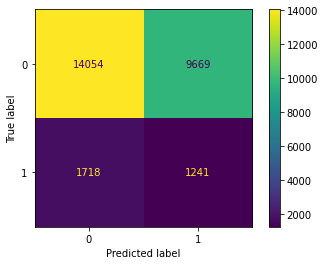

In [126]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()